In [8]:
import sys
print(sys.executable)

/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/bin/python


In [9]:
import sys, subprocess

print("Using Python:", sys.executable)

packages = [
    "scikit-learn",
    "xgboost",
    "tensorflow",
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
]

subprocess.check_call([sys.executable, "-m", "pip", "install"] + packages)
print("Packages installed.")

Using Python: /Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/bin/python
Packages installed.


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd
from pathlib import Path

print("All imports successful.")

All imports successful.


In [12]:
from pathlib import Path

DATA_DIR = Path("..") / "data"

print("DATA_DIR:", DATA_DIR.resolve())


for p in sorted(DATA_DIR.rglob("*.csv")):
    print(p.relative_to(DATA_DIR))

DATA_DIR: /Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/airbnb-price-forecasting-xgb-vs-nn/data
tier_big/chicago_listings.csv
tier_big/la_listings.csv
tier_big/nyc_listings.csv
tier_big/sf_listings.csv
tier_medium/austin_listings.csv
tier_medium/denver_listings.csv
tier_medium/portland_listings.csv
tier_medium/seattle_listings.csv
tier_small/asheville_listings.csv
tier_small/columbus_listings.csv
tier_small/salem_listings.csv
tier_small/santa_cruz_listings.csv


In [13]:
city_meta = {
    # Big Tier
    "nyc": {
        "pretty": "New York City",
        "tier": "big",
        "path": DATA_DIR / "tier_big" / "nyc_listings.csv",
    },
    "la": {
        "pretty": "Los Angeles",
        "tier": "big",
        "path": DATA_DIR / "tier_big" / "la_listings.csv",
    },
    "sf": {
        "pretty": "San Francisco",
        "tier": "big",
        "path": DATA_DIR / "tier_big" / "sf_listings.csv",
    },
    "chicago": {
        "pretty": "Chicago",
        "tier": "big",
        "path": DATA_DIR / "tier_big" / "chicago_listings.csv",
    },

    # Medium Tier
    "austin": {
        "pretty": "Austin",
        "tier": "medium",
        "path": DATA_DIR / "tier_medium" / "austin_listings.csv",
    },
    "denver": {
        "pretty": "Denver",
        "tier": "medium",
        "path": DATA_DIR / "tier_medium" / "denver_listings.csv",
    },
    "portland": {
        "pretty": "Portland",
        "tier": "medium",
        "path": DATA_DIR / "tier_medium" / "portland_listings.csv",
    },
    "seattle": {
        "pretty": "Seattle",
        "tier": "medium",
        "path": DATA_DIR / "tier_medium" / "seattle_listings.csv",
    },

    # Small Tier
    "asheville": {
        "pretty": "Asheville",
        "tier": "small",
        "path": DATA_DIR / "tier_small" / "asheville_listings.csv",
    },
    "columbus": {
        "pretty": "Columbus",
        "tier": "small",
        "path": DATA_DIR / "tier_small" / "columbus_listings.csv",
    },
    "salem": {
        "pretty": "Salem",
        "tier": "small",
        "path": DATA_DIR / "tier_small" / "salem_listings.csv",
    },
    "santa_cruz": {
        "pretty": "Santa Cruz",
        "tier": "small",
        "path": DATA_DIR / "tier_small" / "santa_cruz_listings.csv",
    },
}

city_meta

{'nyc': {'pretty': 'New York City',
  'tier': 'big',
  'path': PosixPath('../data/tier_big/nyc_listings.csv')},
 'la': {'pretty': 'Los Angeles',
  'tier': 'big',
  'path': PosixPath('../data/tier_big/la_listings.csv')},
 'sf': {'pretty': 'San Francisco',
  'tier': 'big',
  'path': PosixPath('../data/tier_big/sf_listings.csv')},
 'chicago': {'pretty': 'Chicago',
  'tier': 'big',
  'path': PosixPath('../data/tier_big/chicago_listings.csv')},
 'austin': {'pretty': 'Austin',
  'tier': 'medium',
  'path': PosixPath('../data/tier_medium/austin_listings.csv')},
 'denver': {'pretty': 'Denver',
  'tier': 'medium',
  'path': PosixPath('../data/tier_medium/denver_listings.csv')},
 'portland': {'pretty': 'Portland',
  'tier': 'medium',
  'path': PosixPath('../data/tier_medium/portland_listings.csv')},
 'seattle': {'pretty': 'Seattle',
  'tier': 'medium',
  'path': PosixPath('../data/tier_medium/seattle_listings.csv')},
 'asheville': {'pretty': 'Asheville',
  'tier': 'small',
  'path': PosixPath('.

In [14]:
import numpy as np
import pandas as pd
from pathlib import Path

# Base numeric columns from the assignment 
base_numeric_cols = [
    "accommodates",
    "bedrooms",
    "beds",
    "bathrooms_text",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "number_of_reviews",
    "availability_365",
    "minimum_nights",
    "maximum_nights",
]

# 4 engineered features (all numeric)
engineered_cols = [
    "neighbourhood_popularity",  # share of listings in this neighbourhood (location demand)
    "property_type_encoded",     # property_type mapped to its avg price (type "expensiveness")
    "recent_review_ratio",       # recent reviews vs total reviews (current popularity)
    "host_engagement_score",     # composite host behavior score (response/acceptance/superhost)
]


def load_and_clean_city(path: Path) -> pd.DataFrame:

    df = pd.read_csv(path)

    #   Clean target: price  
    df["price"] = (
        df["price"]
        .astype(str)
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
    )
    df["price"] = pd.to_numeric(df["price"], errors="coerce")

    #   bathrooms_text -> numeric  
    df["bathrooms_text"] = (
        df["bathrooms_text"]
        .astype(str)
        .str.extract(r"([\d\.]+)", expand=False)
    )
    df["bathrooms_text"] = pd.to_numeric(df["bathrooms_text"], errors="coerce")

    # Drop rows with no price early (we need price for property_type encoding)
    df = df.dropna(subset=["price"])

    
    # 1) neighbourhood_popularity  (location feature)  = fraction of listings in this neighbourhood within the city
    
    neigh_counts = df["neighbourhood_cleansed"].value_counts(normalize=True)
    df["neighbourhood_popularity"] = df["neighbourhood_cleansed"].map(neigh_counts)

    
    # 2) property_type_encoded  (location / property feature) = avg price for each property_type, min-max scaled to [0, 1]
    
    type_mean_price = df.groupby("property_type")["price"].mean()
    # avoid division by zero if only one property_type
    if type_mean_price.max() != type_mean_price.min():
        type_score = (type_mean_price - type_mean_price.min()) / (
            type_mean_price.max() - type_mean_price.min()
        )
    else:
        type_score = pd.Series(0.5, index=type_mean_price.index)
    df["property_type_encoded"] = df["property_type"].map(type_score)

    
    # 3) recent_review_ratio  (popularity feature) = number_of_reviews_l30d / (number_of_reviews + 1)
    
    if "number_of_reviews_l30d" in df.columns:
        df["recent_review_ratio"] = df["number_of_reviews_l30d"] / (
            df["number_of_reviews"].fillna(0) + 1
        )
    else:
        df["recent_review_ratio"] = 0.0  # fallback if column missing (shouldn't happen)

    
    # 4) host_engagement_score  (host behavior feature) = 0.5 * response_rate + 0.3 * acceptance_rate + 0.2 * is_superhost
    

    # Parse percentage strings like "97%" -> 0.97
    def parse_percent(s):
        if isinstance(s, str) and s.strip().endswith("%"):
            try:
                return float(s.strip().strip("%")) / 100.0
            except ValueError:
                return np.nan
        return np.nan

    df["host_response_rate_num"] = df.get("host_response_rate", np.nan).apply(parse_percent)
    df["host_acceptance_rate_num"] = df.get("host_acceptance_rate", np.nan).apply(parse_percent)

    # host_is_superhost usually "t"/"f" or "TRUE"/"FALSE"
    df["host_is_superhost_num"] = (
        df.get("host_is_superhost", "").astype(str).str.lower().isin(["t", "true", "1"])
    ).astype(float)

    df["host_engagement_score"] = (
        0.5 * df["host_response_rate_num"].fillna(0.0)
        + 0.3 * df["host_acceptance_rate_num"].fillna(0.0)
        + 0.2 * df["host_is_superhost_num"].fillna(0.0)
    )

    #   Final feature selection  
    feature_cols = base_numeric_cols + engineered_cols

    # Some base columns might have missing values; we won't drop them yet — models can handle NaNs or we'll impute later.
    df_clean = df[feature_cols + ["price"]].copy()

    return df_clean

In [15]:
# Load and clean New York City data
nyc_df = load_and_clean_city(city_meta["nyc"]["path"])

print("NYC shape:", nyc_df.shape)
nyc_df.head()

NYC shape: (21328, 20)


,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights,neighbourhood_popularity,property_type_encoded,recent_review_ratio,host_engagement_score,price
0,1,1.0,1.0,1.0,4.81,4.81,4.88,4.81,4.88,4.94,4.69,16,77,30,365,0.006705,0.008636,0.0,0.862,66.0
4,1,1.0,1.0,2.0,4.95,4.80,4.85,5.00,5.00,5.00,4.95,20,168,30,900,0.017958,0.006380,0.0,0.857,76.0
5,6,2.0,3.0,1.0,4.14,4.26,4.09,4.45,4.06,4.46,4.00,93,364,30,365,0.003001,0.021904,0.0,0.875,97.0
7,1,2.0,1.0,1.0,4.92,4.81,4.96,4.88,4.88,4.88,4.77,26,187,30,35,0.038447,0.006380,0.0,0.380,60.0
8,6,3.0,3.0,4.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,1,224,30,90,0.031414,0.021904,0.0,0.000,425.0


In [16]:
cleaned_cities = {}

for key, meta in city_meta.items():
    df_clean = load_and_clean_city(meta["path"])
    df_clean["city"] = meta["pretty"]
    df_clean["tier"] = meta["tier"]
    cleaned_cities[key] = df_clean

len(cleaned_cities), list(cleaned_cities.keys())

(12,
 ['nyc',
  'la',
  'sf',
  'chicago',
  'austin',
  'denver',
  'portland',
  'seattle',
  'asheville',
  'columbus',
  'salem',
  'santa_cruz'])

In [17]:
# Combine cleaned city data by tier

big_tier_df = pd.concat(
    [cleaned_cities[c] for c in ["nyc", "la", "sf", "chicago"]],
    ignore_index=True,
)

medium_tier_df = pd.concat(
    [cleaned_cities[c] for c in ["austin", "denver", "portland", "seattle"]],
    ignore_index=True,
)

small_tier_df = pd.concat(
    [cleaned_cities[c] for c in ["asheville", "columbus", "salem", "santa_cruz"]],
    ignore_index=True,
)

big_tier_df.shape, medium_tier_df.shape, small_tier_df.shape

((71623, 22), (25028, 22), (7063, 22))

In [18]:
# Build a summary table for the README

summary_rows = []

for key, meta in city_meta.items():
    dfc = cleaned_cities[key]
    summary_rows.append({
        "city_key": key,
        "city": meta["pretty"],
        "tier": meta["tier"],
        "cleaned_rows": len(dfc)
    })

city_summary = pd.DataFrame(summary_rows)
city_summary

,city_key,city,tier,cleaned_rows
0,nyc,New York City,big,21328
1,la,Los Angeles,big,36819
2,sf,San Francisco,big,5795
3,chicago,Chicago,big,7681
4,austin,Austin,medium,10708
5,denver,Denver,medium,4301
6,portland,Portland,medium,3798
7,seattle,Seattle,medium,6221
8,asheville,Asheville,small,2536
9,columbus,Columbus,small,2694


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd

def train_xgb_model(
    df: pd.DataFrame,
    test_size: float = 0.2,
    random_state: int = 42,
    n_estimators: int = 400,      # different from example (100)
    learning_rate: float = 0.03,  # smaller LR than example (0.1)
    max_depth: int = 5,           # shallower than example (6)
    subsample: float = 0.9,
    colsample_bytree: float = 0.9,
):
    """
    Train one XGBoost regressor on a (city or tier) DataFrame.

    NOTE: Hyperparameters are intentionally different from the assignment example.
          - More trees (400)
          - Smaller learning rate (0.03)
          - Shallower depth (5)
          - Subsampling for regularization

    Returns:
        model : trained XGBRegressor
        metrics : dict with RMSE, MAE, R^2
    """

    # Use all numeric feature columns except price + identifiers
    feature_cols = [c for c in df.columns if c not in ["price", "city", "tier"]]
    X = df[feature_cols]
    y = df["price"]


    # ---- FIX: handle NaNs in engineered + base numeric features ----
    # Impute features
    X = X.copy()
    for col in X.columns:
        if X[col].isna().any():
            X[col] = X[col].fillna(X[col].median())

    # Drop NaN targets
    y = y.dropna()
    X = X.loc[y.index]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=random_state,
        objective="reg:squarederror",
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # --- FIX: sklearn version doesn't support squared=False ---
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    metrics = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }
    return model, metrics

In [26]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd


def build_nn_model(input_dim: int, arch: str = "A"):
    """
    Build one of two neural network architectures.
    
    Note: These are intentionally different from the assignment examples.
          - Architecture A: Wide + shallow (128 -> 64)
          - Architecture B: Deep + regularized (256 -> 128 -> 64 -> 32 + dropout)
    """

    model = keras.Sequential()

    if arch == "A":
        # Wide and simple architecture (NOT from PDF)
        model.add(layers.Dense(128, activation="relu", input_shape=(input_dim,)))
        model.add(layers.Dense(64, activation="relu"))

    elif arch == "B":
        # Deeper network with dropout + batchnorm (also NOT from PDF)
        model.add(layers.Dense(256, activation="relu", input_shape=(input_dim,)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.3))

        model.add(layers.Dense(128, activation="relu"))
        model.add(layers.BatchNormalization())

        model.add(layers.Dense(64, activation="relu"))
        model.add(layers.Dense(32, activation="relu"))

    else:
        raise ValueError("arch must be 'A' or 'B'.")

    # Final output layer
    model.add(layers.Dense(1))

    # Compile with MSE loss + MAE metric (standard for regression)
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )

    return model



def train_nn_model(
    df: pd.DataFrame,
    arch: str = "A",
    test_size: float = 0.2,
    random_state: int = 42,
    epochs: int = 25,
    batch_size: int = 64,
):
    """
    Train a neural network model on one city or tier.
    Returns:
        model, scaler, history, metrics
    """

    feature_cols = [c for c in df.columns if c not in ["price", "city", "tier"]]
    X = df[feature_cols]
    y = df["price"]

    
    # ---- FIX: handle NaNs in engineered + base numeric features ----
    X = X.copy()
    for col in X.columns:
        if X[col].isna().any():
            X[col] = X[col].fillna(X[col].median())

    y = y.dropna()
    X = X.loc[y.index]


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Scale input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build NN
    model = build_nn_model(X_train.shape[1], arch=arch)

    # Train
    history = model.fit(
        X_train_scaled,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,   # silent training
        validation_split=0.1,
    )

    # Predict + metrics
    preds = model.predict(X_test_scaled).flatten()

    # --- FIX: sklearn version doesn't support squared=False ---
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    metrics = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
    }

    return model, scaler, history, metrics

In [28]:
# Picking NYC for initial model testing
nyc = cleaned_cities["nyc"]

print("Training XGBoost on NYC...")
xgb_nyc_model, xgb_nyc_metrics = train_xgb_model(nyc)

print("Training Neural Network A on NYC...")
nnA_nyc_model, nnA_scaler, nnA_hist, nnA_metrics = train_nn_model(nyc, arch="A")

print("Training Neural Network B on NYC...")
nnB_nyc_model, nnB_scaler, nnB_hist, nnB_metrics = train_nn_model(nyc, arch="B")

print("\n--- NYC Model Performance ---")
print("XGBoost:", xgb_nyc_metrics)
print("NN A:", nnA_metrics)
print("NN B:", nnB_metrics)

Training XGBoost on NYC...
Training Neural Network A on NYC...


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
Training Neural Network B on NYC...


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step

--- NYC Model Performance ---
XGBoost: {'rmse': np.float64(1580.5635331905517), 'mae': 233.0513724228948, 'r2': 0.8869995067630067}
NN A: {'rmse': np.float64(3351.5077426049984), 'mae': 593.6652195592806, 'r2': 0.4919144100242986}
NN B: {'rmse': np.float64(2285.677789201195), 'mae': 309.9282843962668, 'r2': 0.7636876385744854}


In [29]:
# Evaluate XGBoost, NN A, NN B for all 12 cities

city_order = [
    "nyc", "la", "sf", "chicago",
    "austin", "denver", "portland", "seattle",
    "asheville", "columbus", "salem", "santa_cruz",
]

all_results = []

for key in city_order:
    df = cleaned_cities[key]
    city_name = df["city"].iloc[0]
    tier = df["tier"].iloc[0]

    print(f"\n=== {city_name} ({tier}) ===")

    # XGBoost
    xgb_model, xgb_metrics = train_xgb_model(df)
    print("  XGB  ->", xgb_metrics)

    # NN A
    nnA_model, nnA_scaler, nnA_hist, nnA_metrics = train_nn_model(df, arch="A")
    print("  NN A ->", nnA_metrics)

    # NN B
    nnB_model, nnB_scaler, nnB_hist, nnB_metrics = train_nn_model(df, arch="B")
    print("  NN B ->", nnB_metrics)

    # Store results in long format (one row per city+model)
    all_results.append({
        "city_key": key,
        "city": city_name,
        "tier": tier,
        "model": "XGB",
        **xgb_metrics,
    })
    all_results.append({
        "city_key": key,
        "city": city_name,
        "tier": tier,
        "model": "NN_A",
        **nnA_metrics,
    })
    all_results.append({
        "city_key": key,
        "city": city_name,
        "tier": tier,
        "model": "NN_B",
        **nnB_metrics,
    })

# Turn into a DataFrame for later plots / tables
city_results_df = pd.DataFrame(all_results)
city_results_df


=== New York City (big) ===
  XGB  -> {'rmse': np.float64(1580.5635331905517), 'mae': 233.0513724228948, 'r2': 0.8869995067630067}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
  NN A -> {'rmse': np.float64(3285.498331769519), 'mae': 592.5881593458065, 'r2': 0.5117312542451689}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step
  NN B -> {'rmse': np.float64(2531.65116979321), 'mae': 352.60211475136913, 'r2': 0.7100893604896727}

=== Los Angeles (big) ===
  XGB  -> {'rmse': np.float64(1111.8440551226004), 'mae': 175.86200392477332, 'r2': 0.6059168292606107}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
  NN A -> {'rmse': np.float64(1435.0543019217807), 'mae': 265.8538025419457, 'r2': 0.34349686845638816}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
  NN B -> {'rmse': np.float64(2404.7375903999814), 'mae': 253.89592056106704, 'r2': -0.8434676324279997}

=== San Francisco (big) ===
  XGB  -> {'rmse': np.float64(1861.0190104028018), 'mae': 218.83593438862727, 'r2': -0.5528069061958678}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
  NN A -> {'rmse': np.float64(1442.9995631827749), 'mae': 304.6529290434407, 'r2': 0.06642710474308144}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  NN B -> {'rmse': np.float64(1362.9705079208659), 'mae': 164.60027976772517, 'r2': 0.16710788196990223}

=== Chicago (big) ===
  XGB  -> {'rmse': np.float64(1687.1103841956947), 'mae': 182.56124517152895, 'r2': 0.8060851215971818}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
  NN A -> {'rmse': np.float64(2270.817534427344), 'mae': 641.1619886056354, 'r2': 0.6486915360234182}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
  NN B -> {'rmse': np.float64(2813.6741091663826), 'mae': 344.38875213193677, 'r2': 0.46064870749506837}

=== Austin (medium) ===
  XGB  -> {'rmse': np.float64(1145.693558311445), 'mae': 164.81544645605078, 'r2': 0.7568343662483726}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
  NN A -> {'rmse': np.float64(2089.796739731693), 'mae': 406.95283078223497, 'r2': 0.19095375081612287}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
  NN B -> {'rmse': np.float64(2245.1126220179467), 'mae': 262.7389499190586, 'r2': 0.06622655927179621}

=== Denver (medium) ===
  XGB  -> {'rmse': np.float64(218.8333658017846), 'mae': 60.90326813399861, 'r2': 0.22253989147782705}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
  NN A -> {'rmse': np.float64(222.47762368100805), 'mae': 68.83549892943911, 'r2': 0.19643001134014448}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
  NN B -> {'rmse': np.float64(226.7832730302259), 'mae': 63.07569199627423, 'r2': 0.16502576957826554}

=== Portland (medium) ===
  XGB  -> {'rmse': np.float64(427.4107903061832), 'mae': 88.01495088087886, 'r2': 0.9874079951884028}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
  NN A -> {'rmse': np.float64(3193.702919664003), 'mae': 759.9489842187601, 'r2': 0.29693909720012357}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
  NN B -> {'rmse': np.float64(2973.513737372817), 'mae': 371.3677137575651, 'r2': 0.39054195342767617}

=== Seattle (medium) ===
  XGB  -> {'rmse': np.float64(1551.2735972225319), 'mae': 167.1200912921783, 'r2': 0.8838091284249464}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
  NN A -> {'rmse': np.float64(3201.6051671302707), 'mae': 746.2859433432121, 'r2': 0.5050848455841256}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  NN B -> {'rmse': np.float64(2410.2201625565895), 'mae': 282.99557812778824, 'r2': 0.7195156474424812}

=== Asheville (small) ===
  XGB  -> {'rmse': np.float64(102.08510715267357), 'mae': 54.99715520171669, 'r2': 0.6134407472826089}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  NN A -> {'rmse': np.float64(104.62903350651835), 'mae': 62.724282279727966, 'r2': 0.5939348462735146}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
  NN B -> {'rmse': np.float64(120.74516034045003), 'mae': 62.25596411397138, 'r2': 0.4592073751514696}

=== Columbus (small) ===
  XGB  -> {'rmse': np.float64(1711.1383730945474), 'mae': 145.94841767772894, 'r2': 0.6124794298931002}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  NN A -> {'rmse': np.float64(2393.7931680691036), 'mae': 400.85268307343154, 'r2': 0.24160101101758102}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
  NN B -> {'rmse': np.float64(1085.2965170015152), 'mae': 171.91065642853476, 'r2': 0.8441089014286611}

=== Salem (small) ===
  XGB  -> {'rmse': np.float64(69.027171862001), 'mae': 33.17336014338902, 'r2': -0.8812578636992703}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
  NN A -> {'rmse': np.float64(70.4795833139402), 'mae': 56.63422410828726, 'r2': -0.9612584316328925}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/stepWARNING:tensorflow:6 out of the last 21 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x16e955510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
  NN B -> {'rmse': np.float64(68.94093118739835), 'mae': 56.718811529023306, 'r2': -0.8765600152092989}

=== Santa Cruz (small) ===
  XGB  -> {'rmse': np.float64(3952.49096589855), 'mae': 589.6830828845309

/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
  NN A -> {'rmse': np.float64(3824.819014538793), 'mae': 691.3296780724235, 'r2': 0.07784706884118742}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  NN B -> {'rmse': np.float64(3091.162000286121), 'mae': 595.3684534213934, 'r2': 0.39768357898479556}


,city_key,city,tier,model,rmse,mae,r2
0,nyc,New York City,big,XGB,1580.563533,233.051372,0.887000
1,nyc,New York City,big,NN_A,3285.498332,592.588159,0.511731
2,nyc,New York City,big,NN_B,2531.651170,352.602115,0.710089
3,la,Los Angeles,big,XGB,1111.844055,175.862004,0.605917
4,la,Los Angeles,big,NN_A,1435.054302,265.853803,0.343497
5,la,Los Angeles,big,NN_B,2404.737590,253.895921,-0.843468
6,sf,San Francisco,big,XGB,1861.019010,218.835934,-0.552807
7,sf,San Francisco,big,NN_A,1442.999563,304.652929,0.066427
8,sf,San Francisco,big,NN_B,1362.970508,164.600280,0.167108
9,chicago,Chicago,big,XGB,1687.110384,182.561245,0.806085


In [30]:
# Build composite tier datasets + train tier-level XGB and NN_B

tier_groups = {
    "big":    ["nyc", "la", "sf", "chicago"],
    "medium": ["austin", "denver", "portland", "seattle"],
    "small":  ["asheville", "columbus", "salem", "santa_cruz"],
}

tier_data = {}
tier_results = []
tier_nn_models = {}  # for cross-tier NN analysis later

for tier, keys in tier_groups.items():
    # Combine all cities in this tier
    df_tier = pd.concat([cleaned_cities[k] for k in keys], ignore_index=True)
    tier_data[tier] = df_tier

    print(f"\n=== Tier: {tier.upper()} (combined {len(keys)} cities, {len(df_tier)} listings) ===")

    # XGBoost on tier
    xgb_model, xgb_metrics = train_xgb_model(df_tier)
    print("  XGB  ->", xgb_metrics)

    # Use NN_B as the "tier neural network" (deeper, regularized)
    nn_model, nn_scaler, nn_hist, nn_metrics = train_nn_model(df_tier, arch="B")
    print("  NN_B ->", nn_metrics)

    # Save NN model + scaler for cross-tier experiments later
    tier_nn_models[tier] = {
        "model": nn_model,
        "scaler": nn_scaler,
    }

    # Store metrics for table
    tier_results.append({
        "tier": tier,
        "model": "XGB",
        **xgb_metrics,
    })
    tier_results.append({
        "tier": tier,
        "model": "NN_B",
        **nn_metrics,
    })

tier_results_df = pd.DataFrame(tier_results)
tier_results_df


=== Tier: BIG (combined 4 cities, 71623 listings) ===
  XGB  -> {'rmse': np.float64(1593.282141292775), 'mae': 219.88208924700712, 'r2': 0.743801904222719}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
  NN_B -> {'rmse': np.float64(2199.3263231160063), 'mae': 269.7672818925202, 'r2': 0.5118313729325698}

=== Tier: MEDIUM (combined 4 cities, 25028 listings) ===
  XGB  -> {'rmse': np.float64(953.1668251373328), 'mae': 141.7667644982618, 'r2': 0.8832988528280559}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
  NN_B -> {'rmse': np.float64(1903.3696031666288), 'mae': 210.75375153829802, 'r2': 0.5346458973039843}

=== Tier: SMALL (combined 4 cities, 7063 listings) ===
  XGB  -> {'rmse': np.float64(1476.9743871648607), 'mae': 169.00288551037647, 'r2': 0.5885784815364974}


/Users/aryaapareshdeshpande/Desktop/Basics of AI/Assigment4/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
  NN_B -> {'rmse': np.float64(1196.7612049481809), 'mae': 159.12301152223236, 'r2': 0.7298804116184556}


,tier,model,rmse,mae,r2
0,big,XGB,1593.282141,219.882089,0.743802
1,big,NN_B,2199.326323,269.767282,0.511831
2,medium,XGB,953.166825,141.766764,0.883299
3,medium,NN_B,1903.369603,210.753752,0.534646
4,small,XGB,1476.974387,169.002886,0.588578
5,small,NN_B,1196.761205,159.123012,0.729880


In [32]:
# Cross-Tier Neural Network Analysis

# We use NN_B models for each tier and test them on other tiers.

cross_results = []

def evaluate_cross_tier(source_tier, target_tier):
    model = tier_nn_models[source_tier]["model"]
    scaler = tier_nn_models[source_tier]["scaler"]

    # Work on a copy so we don't mutate tier_data
    df_target = tier_data[target_tier].copy()
    feature_cols = [c for c in df_target.columns if c not in ["price", "city", "tier"]]

    # 🔧 FIX: drop rows that have NaNs in any feature or in price
    df_target = df_target.dropna(subset=feature_cols + ["price"])

    X = df_target[feature_cols]
    y = df_target["price"]

    # Scale using the source tier’s scaler
    X_scaled = scaler.transform(X)
    preds = model.predict(X_scaled).flatten()

    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)

    cross_results.append({
        "source_model": source_tier,
        "test_on": target_tier,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
    })


# Big NN → Medium & Small
evaluate_cross_tier("big", "medium")
evaluate_cross_tier("big", "small")

# Medium NN → Big & Small
evaluate_cross_tier("medium", "big")
evaluate_cross_tier("medium", "small")

# Small NN → Big & Medium
evaluate_cross_tier("small", "big")
evaluate_cross_tier("small", "medium")

cross_results_df = pd.DataFrame(cross_results)
cross_results_df

676/676 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
676/676 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


,source_model,test_on,rmse,mae,r2
0,big,medium,1507.627604,169.358025,0.278868
1,big,small,4268.463616,941.383304,-7.059351
2,medium,big,2002.225279,236.684434,-0.221693
3,medium,small,5611.777432,1021.126197,-12.930214
4,small,big,4128.647148,194.167168,-4.194594
5,small,medium,1553.612007,135.235889,0.234206


In [34]:
city_results_df.head()



,city_key,city,tier,model,rmse,mae,r2
0,nyc,New York City,big,XGB,1580.563533,233.051372,0.887000
1,nyc,New York City,big,NN_A,3285.498332,592.588159,0.511731
2,nyc,New York City,big,NN_B,2531.651170,352.602115,0.710089
3,la,Los Angeles,big,XGB,1111.844055,175.862004,0.605917
4,la,Los Angeles,big,NN_A,1435.054302,265.853803,0.343497


In [35]:

tier_results_df.head()


,tier,model,rmse,mae,r2
0,big,XGB,1593.282141,219.882089,0.743802
1,big,NN_B,2199.326323,269.767282,0.511831
2,medium,XGB,953.166825,141.766764,0.883299
3,medium,NN_B,1903.369603,210.753752,0.534646
4,small,XGB,1476.974387,169.002886,0.588578


In [36]:

cross_results_df.head()

,source_model,test_on,rmse,mae,r2
0,big,medium,1507.627604,169.358025,0.278868
1,big,small,4268.463616,941.383304,-7.059351
2,medium,big,2002.225279,236.684434,-0.221693
3,medium,small,5611.777432,1021.126197,-12.930214
4,small,big,4128.647148,194.167168,-4.194594


<Figure size 1200x600 with 0 Axes>

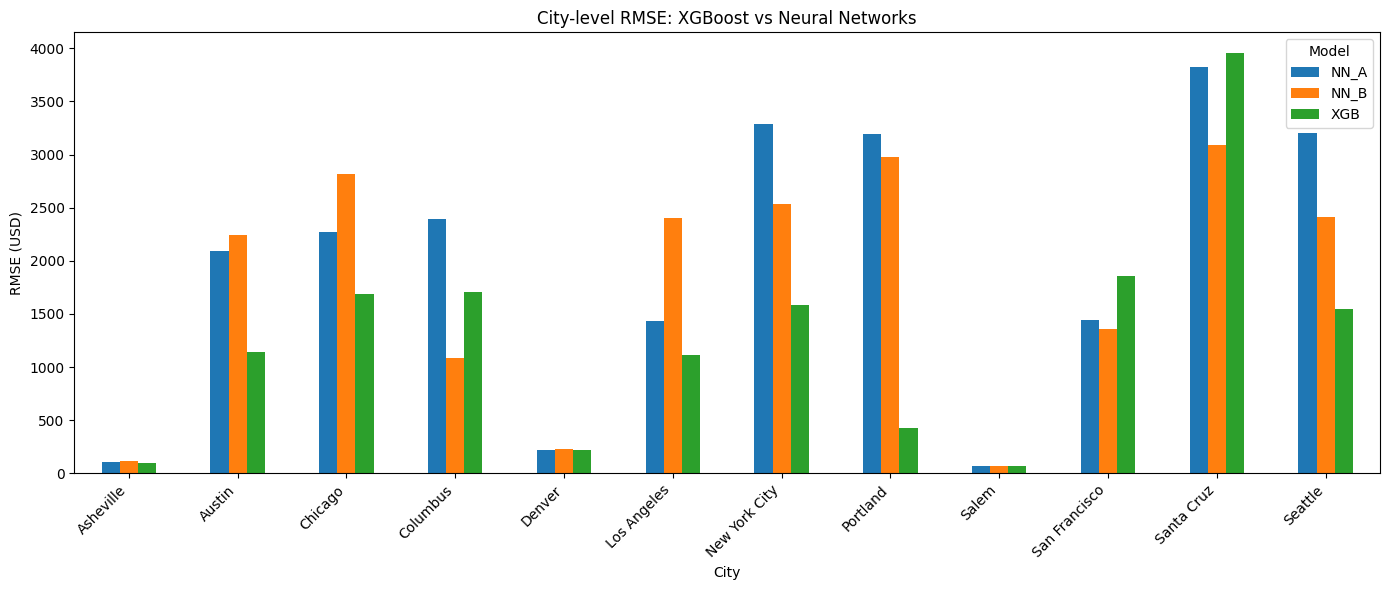

In [37]:
import matplotlib.pyplot as plt

# Pivot so we get one row per city, one column per model (values = RMSE)
city_rmse_pivot = (
    city_results_df
    .pivot(index="city", columns="model", values="rmse")
    .loc[sorted(city_results_df["city"].unique())]  # keep cities in alpha order
)

plt.figure(figsize=(12, 6))
city_rmse_pivot.plot(kind="bar", figsize=(14, 6))

plt.title("City-level RMSE: XGBoost vs Neural Networks")
plt.ylabel("RMSE (USD)")
plt.xlabel("City")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

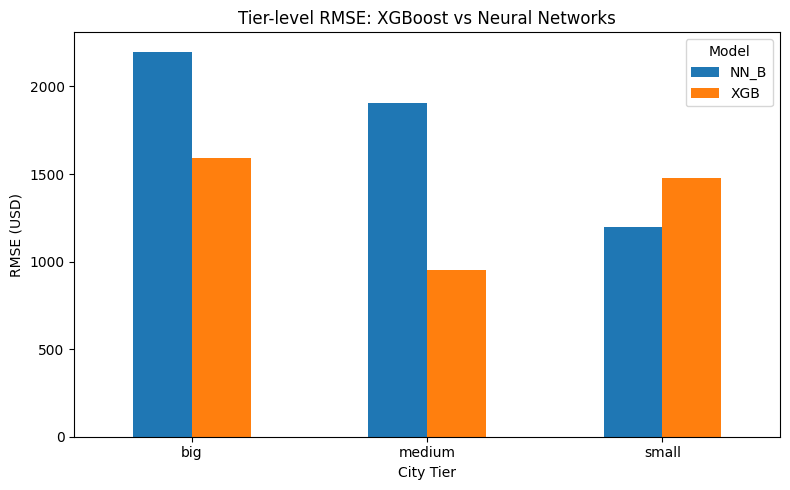

In [38]:
# Pivot: one row per tier, columns = model, values = RMSE
tier_rmse_pivot = (
    tier_results_df
    .pivot(index="tier", columns="model", values="rmse")
    .loc[["big", "medium", "small"]]  # enforce order
)

plt.figure(figsize=(8, 5))
tier_rmse_pivot.plot(kind="bar", figsize=(8, 5))

plt.title("Tier-level RMSE: XGBoost vs Neural Networks")
plt.ylabel("RMSE (USD)")
plt.xlabel("City Tier")
plt.xticks(rotation=0)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

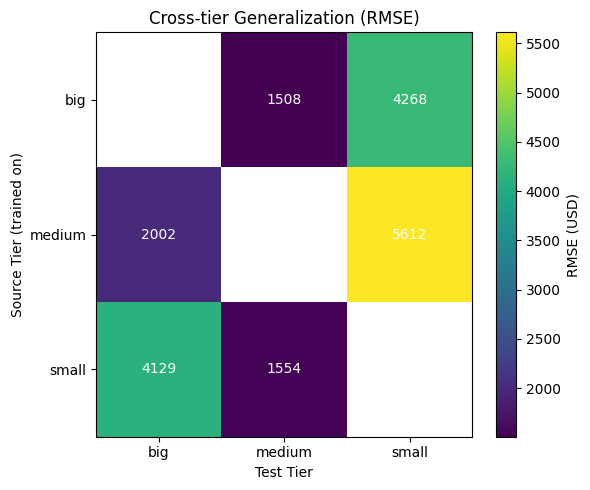

In [39]:
import numpy as np

# Pivot: rows = source tier model was trained on, cols = tier it is tested on
cross_rmse_pivot = cross_results_df.pivot(
    index="source_model", columns="test_on", values="rmse"
).loc[["big", "medium", "small"], ["big", "medium", "small"]]

plt.figure(figsize=(6, 5))
im = plt.imshow(cross_rmse_pivot.values, aspect="auto")

plt.xticks(ticks=np.arange(3), labels=["big", "medium", "small"])
plt.yticks(ticks=np.arange(3), labels=["big", "medium", "small"])
plt.xlabel("Test Tier")
plt.ylabel("Source Tier (trained on)")
plt.title("Cross-tier Generalization (RMSE)")

# Add numeric labels on each cell
for i in range(cross_rmse_pivot.shape[0]):
    for j in range(cross_rmse_pivot.shape[1]):
        val = cross_rmse_pivot.values[i, j]
        plt.text(j, i, f"{val:.0f}", ha="center", va="center", color="white")

plt.colorbar(im, label="RMSE (USD)")
plt.tight_layout()
plt.show()